In [34]:
import json
import os
from statsmodels.stats.contingency_tables import mcnemar
from collections import defaultdict
from tqdm import tqdm 
import plotly.plotly as py
import plotly.graph_objs as go
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
# Paths
# at the lab
# results_dir = os.path.abspath("../results/pairtest/classifier_results/")
# at home
results_dir = os.path.abspath("/Volumes/Elements/darth_linguo/results/pairtest/classifier_results/")
plots_dir = "/Users/pablo/Dropbox/Universidad/Thesis/Dissertation/Results/figures"
tables_dir = "/Users/pablo/Dropbox/Universidad/Thesis/Dissertation/Results/tables"

noisenames = {"AA":"adjectival agreement", "VA": "verbal agreement", "RV":"main verb removal"}

def build_contingency_table( first_table, second_table):
    yes_yes = 0
    yes_no = 0
    no_yes = 0
    no_no = 0
    if not first_table or not second_table:
        print("Warning, one of your experiments is empty, double check experiment names")
        return None
    if len(first_table) != len(second_table):
        print("Warning, tables are different lengths, please reevaluate,  your life")
        return None

    for first,second in zip(first_table, second_table):
        if first and second:
            yes_yes += 1
        elif not (first or second):
            no_no +=1
        elif first and not second:
            yes_no +=1
        elif second and not first:
            no_yes +=1
    contingency_table = [[yes_yes,yes_no],[no_yes,no_no]]
    return contingency_table
    
def convert_pairwise_to_df(pairwise, symmetric=True):
    #Converts a dictionary of single pairwise comparissons to a symmetric dataframe
    df = pd.DataFrame.from_dict(pairwise,orient='columns')
    if symmetric:
        for rowname, row in df.iterrows():
            for columname, value in row.iteritems():
                if columname == rowname:
                    df.loc[columname,rowname] = "-"
                elif np.isnan(value):
                    df.loc[rowname,columname] = df.loc[columname,rowname]
    return df

In [37]:
noise_types = ["AA","RV","VA"]
accuracy_tables = {ntype:defaultdict(list) for ntype in noise_types}
accuracy_numbers = {ntype:{} for ntype in noise_types}
accuracy_G = {ntype:{} for ntype in noise_types}
accuracy_U = {ntype:{} for ntype in noise_types}
pvalue_df = {}
mcnemar_df = {}
target_experiment = input("What experiment do you wish to generate stats for?")
cond_num = 0
for filename in tqdm(os.listdir(results_dir)):
    fullpath = os.path.join(results_dir, filename)
    results = []
    if not os.path.isdir(fullpath):
        parameters = filename.split("_") 
        exp_id = parameters[0]
        condition = parameters[1]
        exp_name = "_".join(parameters[0:-2])
        noise_type = parameters[-2]
        
        if exp_id == target_experiment:
            correct_count = 0
            correct_G = 0
            correct_U = 0
            with open(fullpath, "r") as res_file:
                for line in res_file.readlines():
                    obj = json.loads(line)
                    results.append(obj)
            for result in results:
                is_correct = result["gold_label"] == result["predicted_label"]
                if is_correct:
                    correct_count+=1
                    if result["gold_label"] == "grammatical":
                        correct_G +=1
                    else:
                        correct_U +=1
                accuracy_tables[noise_type][condition].append(is_correct)
            
            accuracy_numbers[noise_type][condition] = correct_count/ len(results)
            accuracy_G[noise_type][condition] = correct_G / (len(results)/2)
            accuracy_U[noise_type][condition] = correct_U / (len(results)/2)
            cond_num+=1

message = "Finished loading data, {} conditions loaded from experiment {}".format(cond_num, target_experiment)
print(message)

What experiment do you wish to generate stats for? exp-2.1


100%|██████████| 75/75 [00:53<00:00,  2.65s/it]

Finished loading data, 18 conditions loaded from experiment exp-2.1


In [38]:
accuracy_numbers['AA']

{'1uni-1-layer': 0.926557134325387,
 '2uni-2-layer': 0.9322120887871398,
 '3uni-3-layer': 0.9217793510177674,
 '4bi-1-layer': 0.9229644652366495,
 '5bi-2-layer': 0.9229333598765739,
 '6bi-3-layer': 0.9204044941024238}

In [39]:

for noise_type in ["VA","AA","RV"]:
    pairwise_mcnemar = {name:{} for name in accuracy_tables[noise_type]}
    pairwise_p_value = {name:{} for name in accuracy_tables[noise_type]}
    experiment_names = sorted(list(accuracy_tables[noise_type]))
    for ind, first_experiment in tqdm(enumerate(experiment_names)):
        first_table = accuracy_tables[noise_type][first_experiment]
        pairwise_mcnemar[first_experiment][first_experiment] = "-"
        pairwise_p_value[first_experiment][first_experiment] = "-"
        for second_experiment in experiment_names[ind+1:]:
            second_table = accuracy_tables[noise_type][second_experiment]
            cont_table = build_contingency_table(first_table,second_table)
            if cont_table[0][1] + cont_table[1][0] < 25:
                stats_result = mcnemar(cont_table, exact=True)
                print("Comparisson between {} and {} has less than 25 disagreement".format(first_experiment,second_experiment))
            if cont_table[0][1] + cont_table[1][0]:
                stats_result = mcnemar(cont_table, exact=False, correction=True)
            pairwise_mcnemar[first_experiment][second_experiment] = stats_result.statistic
            pairwise_p_value[first_experiment][second_experiment] = stats_result.pvalue
    pvalue_df[noise_type] = convert_pairwise_to_df(pairwise_p_value)
    mcnemar_df[noise_type] = convert_pairwise_to_df(pairwise_mcnemar)
    

6it [00:00, 25.74it/s]
6it [00:00, 18.88it/s]
6it [00:00, 21.02it/s]


In [40]:

def build_pvalues_table(ordered_conds,p_values, caption):
    latex_table = """\\begin{table}[ht]
	\\centering
	\\begin{tabular}"""
    #set the number of columns
    cols="{"+"|c"*(len(ordered_conds)+1)+"|}\n\t\hline"
    latex_table+=cols
    #define the colors
    highsigni_color="YellowGreen"
    lowsigni_color = "Dandelion"
    unsigni_color="myOrange"
    # Build the header
    
    header = " &"+"&".join(ordered_conds)+ "\t\\\\\n\hline\n\t"
    latex_table+= header
    for this_condition in ordered_conds:
        latex_cells =[]
        latex_cells.append(this_condition)
        for that_condition in ordered_conds:
            if this_condition == that_condition:
                latex_cells.append("-")
            else:
                pval = p_values.loc[this_condition,that_condition]
                if pval<=0.001:
                    color= highsigni_color
                elif pval <=0.05:
                    color= lowsigni_color
                else:
                    color=unsigni_color
                this_cell = "{{\cellcolor{{{color}}}}}{value:.3g}".format(color=color,
                                                                        value=pval)
                latex_cells.append(this_cell)
        row="&".join(latex_cells)+ "\\\\\n"
        latex_table+=row
        latex_table+="\t\\hline\n\t"
    latex_table += """	\end{{tabular}} 
		\caption{{{}}}
\end{{table}}""".format(caption)
    return latex_table



def build_LATEX_pairwise_table(ordered_conds,accuracies,p_values, caption):
    latex_table = """\\begin{table}[ht]
	\\centering
	\\begin{tabular}"""
    #set the number of columns
    cols="{"+"|c"*(len(ordered_conds)+1)+"|}\n\t\hline"
    latex_table+=cols
    #define the colors
    highsigni_color="YellowGreen"
    lowsigni_color = "Dandelion"
    unsigni_color="myOrange"
    # Build the header
    
    header = " &"+"&".join(ordered_conds)+ "\t\\\\\n\hline\n\t"
    latex_table+= header
    for this_condition in ordered_conds:
        latex_cells =[]
        latex_cells.append(this_condition)
        for that_condition in ordered_conds:
            if this_condition == that_condition:
                latex_cells.append("-")
            else:
                pval = p_values.loc[this_condition,that_condition]
                if pval<=0.001:
                    color= highsigni_color
                elif pval <=0.05:
                    color= lowsigni_color
                else:
                    color=unsigni_color                
                value = accuracies[this_condition] - accuracies[that_condition]
                this_cell = "{{\cellcolor{{{color}}}}}{value:+.2g}".format(color=color,
                                                                        value=value)
                latex_cells.append(this_cell)
        row="&".join(latex_cells)+ "\\\\\n"
        latex_table+=row
        latex_table+="\t\\hline\n\t"
    latex_table += """	\end{{tabular}} 
		\caption{{{}}}
\end{{table}}""".format(caption)
    return latex_table



def build_relative_table(original_ordered_conds,all_accuracies,all_p_values, baseline, caption):
    latex_table = """\\begin{table}[ht]
	\\centering
	\\begin{tabular}"""
    #set the number of columns
    ordered_conds = original_ordered_conds[:]
    ordered_conds.remove(baseline)
    cols="{"+"|c"*(len(ordered_conds)+1)+"|}\n\t\hline"
    latex_table+=cols
    #define the colors
    highsigni_color="YellowGreen"
    lowsigni_color = "Dandelion"
    unsigni_color="myOrange"
    # Build the header
    
    header = " &"+"&".join(ordered_conds)+ "\t\\\\\n\hline\n\t"
    latex_table+= header
    for ug_type in all_accuracies:
        latex_cells = []
        latex_cells.append(ug_type)
        accuracies = all_accuracies[ug_type]
        p_values = all_p_values[ug_type]
        for this_condition in ordered_conds:
            pval = p_values.loc[baseline,this_condition]
            if pval<=0.001:
                color = highsigni_color
            elif pval <=0.05:
                color = lowsigni_color
            else:
                color=unsigni_color                
            value = ((accuracies[this_condition] - accuracies[baseline])/accuracies[baseline]) * 100
            this_cell = "{{\cellcolor{{{color}}}}}{value:+.2g}\%".format(color=color,
                                                                    value=value)
            latex_cells.append(this_cell)
        row="&".join(latex_cells)+ "\\\\\n"
        latex_table+=row
        latex_table+="\t\\hline\n\t"
    latex_table += """	\end{{tabular}} 
        \caption{{{}}}
    \end{{table}}""".format(caption)
    return latex_table





In [41]:
import matplotlib.pyplot as plt

def build_2layer_bar_plot(accuracy_G,accuracy_U,
                          ordered_conds,x_label,
                         title, cond_to_name=None
                         ):
    if cond_to_name is None:
        cond_to_name = {name:name for name in ordered_conds}
    print(ordered_conds)
    #Graph with the G and U accuracies . overimposed 
    AAG_numbers = [ accuracy_G['AA'][cond_to_name[cond]] for cond in ordered_conds ]
    AAU_numbers = [ accuracy_U['AA'][cond_to_name[cond]] for cond in ordered_conds ]

    VAG_numbers = [ accuracy_G['VA'][cond_to_name[cond]] for cond in ordered_conds ]
    VAU_numbers = [ accuracy_U['VA'][cond_to_name[cond]] for cond in ordered_conds ]

    RVG_numbers = [ accuracy_G['RV'][cond_to_name[cond]] for cond in ordered_conds]
    RVU_numbers = [ accuracy_U['RV'][cond_to_name[cond]] for cond in ordered_conds]

    ind = np.arange(len(accuracy_numbers['AA']))
    width = 0.25

    fig, ax = plt.subplots()
    #Make the rectangles
    AAG_rects = ax.bar(ind - width, AAG_numbers, width,
                   color="#ed845e",
                  label= "Adj Agreement (gram)")
    AAU_rects = ax.bar(ind - width, AAU_numbers, width,
                   color="#c1471b",
                  label= "Adj Agreement (ungram)",)

    VAG_rects = ax.bar(ind, VAG_numbers, width,
                   color="skyblue",
                  label= "Verb Agreement (gram)")
    VAU_rects = ax.bar(ind, VAU_numbers, width,
                   color="steelblue",
                  label= "Verbal Agreement (ungram)")

    RVG_rects = ax.bar(ind + width, RVG_numbers, width,
                   color="#a7ce90",
                  label= "Verb Removal (gram)")
    RVU_rects = ax.bar(ind + width, RVU_numbers, width,
                   color="#658752",
                  label= "Verb Removal (ungram)")

    # Add the labels
    ax.set_axisbelow(True)
    ax.grid(which='major',axis='y',alpha=0.8,color='black')

    ax.set_ylabel("Accuracy")
    ax.set_xlabel(x_label)
    ax.set_title(title)
    ax.set_xticks(ind)
    ax.set_xticklabels(ordered_conds, rotation='45')
    ax.set_ylim(bottom=0.5)

    lgd = plt.legend(bbox_to_anchor=(1.03, 0.45), loc=2, borderaxespad=0.)
    plt.show
    plt.savefig(os.path.join(plots_dir,target_experiment.replace(".","-")+"_UandGaccuracies.png")
               ,bbox_extra_artists=(lgd,), bbox_inches='tight')

In [22]:
# For experiment 1.1
if target_experiment=="exp-1.1":
    for noise_type in noise_types:
        ordered_conds= ["32-32","64-64","128-128","256-256","512-512","512-1024"]
        caption = "The relative difference in accuracy accross dimension parameters on {} data, green indicates that the difference is significant according to Mc Nemar's test ($p\\leq0.001$)".format(noise_type)
        table_latex = build_LATEX_pairwise_table(ordered_conds, accuracy_U[noise_type], pvalue_df[noise_type], caption )
        table_folder = "/Users/pablo/Dropbox/Universidad/Thesis/Dissertation/Results/tables"
        with open(os.path.join(table_folder,"exp-1.1_{}_pairwise.tex".format(noise_type)),"w") as outfile:
            outfile.write(table_latex)

    for noise_type in noise_types:
        ordered_conds= ["32-32","64-64","128-128","256-256","512-512","512-1024"]
        caption = "Pairwise p-value accross dimension parameters on {} data, green indicates that the difference is highly significant ($p\\leq 0.001$), orange that it is significant($0.001\\leq p \\leq 0.05$), according to Mc Nemar's test ".format(noise_type)
        table_latex = build_pvalues_table(ordered_conds, pvalue_df[noise_type], caption )
        table_folder = "/Users/pablo/Dropbox/Universidad/Thesis/Dissertation/Results/tables"
        with open(os.path.join(table_folder,"exp-1.1_{}_pvals.tex".format(noise_type)),"w") as outfile:
            outfile.write(table_latex)

In [30]:
# For experiment 1.2
if target_experiment=="exp-1.2":
    for noise_type in noise_types:
        ordered_conds= ["random","pretrained-cont","pretrained-freeze"]
        caption = "The relative difference in accuracy by embedding dimension on {} data, green indicates that the difference in error proportions highly significant ($p\\leq 0.001$), orange that it is significant($0.001\\leq p \\leq 0.05$), red that it is not significant, according to Mc Nemar's test. ".format(noisenames[noise_type])
        table_latex = build_LATEX_pairwise_table(ordered_conds, accuracy_U[noise_type], pvalue_df[noise_type], caption )
        table_folder = "/Users/pablo/Dropbox/Universidad/Thesis/Dissertation/Results/tables"
        with open(os.path.join(table_folder,"exp-1.2_{}_pairwise.tex".format(noise_type)),"w") as outfile:
            outfile.write(table_latex)

    for noise_type in noise_types:
        caption = "Pairwise p-value accross dimension parameters on {} data, green indicates that the difference in error proportions highly significant ($p\\leq 0.001$), orange that it is significant($0.001\\leq p \\leq 0.05$), red that it is not significant, according to Mc Nemar's test. ".format(noisenames[noise_type])
        table_latex = build_pvalues_table(ordered_conds, pvalue_df[noise_type], caption )
        table_folder = "/Users/pablo/Dropbox/Universidad/Thesis/Dissertation/Results/tables"
        with open(os.path.join(table_folder,"exp-1.2_{}_pvals.tex".format(noise_type)),"w") as outfile:
            outfile.write(table_latex)
    baseline = "random"
    relative_table = build_relative_table(ordered_conds, accuracy_numbers, pvalue_df, baseline, caption)
    with open(os.path.join(table_folder,"exp-1.2_relative.tex".format(noise_type)),"w") as outfile:
            outfile.write(relative_table)

In [31]:
relative_table

"\\begin{table}[ht]\n\t\\centering\n\t\\begin{tabular}{|c|c|c|}\n\t\\hline &pretrained-cont&pretrained-freeze\t\\\\\n\\hline\n\tAA&{\\cellcolor{YellowGreen}}+1.9\\%&{\\cellcolor{YellowGreen}}+3.2\\%\\\\\n\t\\hline\n\tRV&{\\cellcolor{YellowGreen}}+0.55\\%&{\\cellcolor{YellowGreen}}+1.3\\%\\\\\n\t\\hline\n\tVA&{\\cellcolor{YellowGreen}}+1\\%&{\\cellcolor{YellowGreen}}+1.9\\%\\\\\n\t\\hline\n\t\t\\end{tabular} \n        \\caption{Pairwise p-value accross dimension parameters on verbal agreement data, green indicates that the difference in error proportions highly significant ($p\\leq 0.001$), orange that it is significant($0.001\\leq p \\leq 0.05$), red that it is not significant, according to Mc Nemar's test. }\n    \\end{table}"

In [24]:
# For experiment 1.3
if target_experiment=="exp-1.3":
    for noise_type in noise_types:
        ordered_conds= ["16-512", "32-512", "64-512", "128-512","256-512", '512-512']
        caption = "The relative difference in accuracy between embeddings on {} data, green indicates that the difference in error proportions highly significant ($p\\leq 0.001$), orange that it is significant($0.001\\leq p \\leq 0.05$), red that it is not significant, according to Mc Nemar's test. ".format(noisenames[noise_type])
        table_latex = build_LATEX_pairwise_table(ordered_conds, accuracy_U[noise_type], pvalue_df[noise_type], caption )
        table_folder = "/Users/pablo/Dropbox/Universidad/Thesis/Dissertation/Results/tables"
        with open(os.path.join(table_folder,"exp-1.3_{}_pairwise.tex".format(noise_type)),"w") as outfile:
            outfile.write(table_latex)

    for noise_type in noise_types:
        caption = "Pairwise p-value accross dimension parameters on {} data, green indicates that the difference in error proportions highly significant ($p\\leq 0.001$), orange that it is significant($0.001\\leq p \\leq 0.05$), red that it is not significant, according to Mc Nemar's test. ".format(noisenames[noise_type])
        table_latex = build_pvalues_table(ordered_conds, pvalue_df[noise_type], caption )
        table_folder = "/Users/pablo/Dropbox/Universidad/Thesis/Dissertation/Results/tables"
        with open(os.path.join(table_folder,"exp-1.3_{}_pvals.tex".format(noise_type)),"w") as outfile:
            outfile.write(table_latex)
        
    title = "Accuracy by embeddings dimension"
    x_label = "Embeddings Dimension"
    build_2layer_bar_plot(accuracy_G,accuracy_U,
                      ordered_conds,x_label,
                     title)

['unidirectional\n 1 layer', 'unidirectional\n 2 layers', 'unidirectional\n 3 layers', 'bidirectional\n 1 layer', 'bidirectional\n 2 layers', 'bidirectional\n 3 layers']


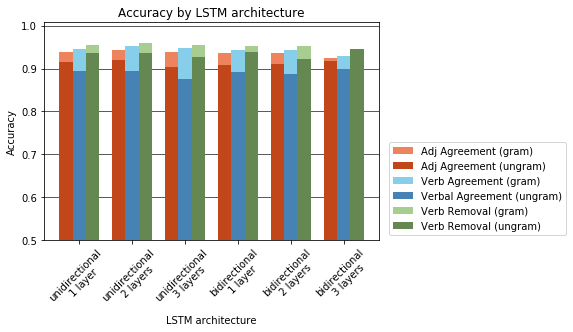

In [43]:
# For experiment 2.1

cond_code_to_name = {'unidirectional\n 1 layer':'1uni-1-layer',
 'unidirectional\n 2 layers':'2uni-2-layer',
 'unidirectional\n 3 layers':'3uni-3-layer',
 'bidirectional\n 1 layer':'4bi-1-layer',
 'bidirectional\n 2 layers':'5bi-2-layer',
 'bidirectional\n 3 layers':'6bi-3-layer'}
if target_experiment=="exp-2.1":
    for noise_type in noise_types:
        ordered_conds= ['unidirectional\n 1 layer',
 'unidirectional\n 2 layers',
 'unidirectional\n 3 layers',
 'bidirectional\n 1 layer',
 'bidirectional\n 2 layers',
 'bidirectional\n 3 layers']
        caption = "The relative difference in accuracy between LSTM architectures on {} data, green indicates that the difference in error proportions highly significant ($p\\leq 0.001$), orange that it is significant($0.001\\leq p \\leq 0.05$), red that it is not significant, according to Mc Nemar's test. ".format(noisenames[noise_type])
        table_latex = build_LATEX_pairwise_table(cond_code_to_name.values(), accuracy_U[noise_type], pvalue_df[noise_type], caption )
        table_folder = "/Users/pablo/Dropbox/Universidad/Thesis/Dissertation/Results/tables"
        with open(os.path.join(table_folder,"{}_{}_pairwise.tex".format(target_experiment,noise_type)),"w") as outfile:
            outfile.write(table_latex)

    for noise_type in noise_types:
        caption = "Pairwise p-value accross LSTM architectures on {} data, green indicates that the difference in error proportions highly significant ($p\\leq 0.001$), orange that it is significant($0.001\\leq p \\leq 0.05$), red that it is not significant, according to Mc Nemar's test. ".format(noisenames[noise_type])
        table_latex = build_pvalues_table(cond_code_to_name.values(), pvalue_df[noise_type], caption )
        table_folder = "/Users/pablo/Dropbox/Universidad/Thesis/Dissertation/Results/tables"
        with open(os.path.join(table_folder,"{}_{}_pvals.tex".format(target_experiment,noise_type)),"w") as outfile:
            outfile.write(table_latex)
    title = "Accuracy by LSTM architecture"
    x_label = "LSTM architecture"
    
    build_2layer_bar_plot(accuracy_G,accuracy_U,
                          ordered_conds,x_label,
                         title,cond_to_name=cond_code_to_name)
    baseline="1uni-1-layer"
    relative_table = build_relative_table(list(cond_code_to_name.values()), accuracy_numbers, pvalue_df, baseline, caption)
    with open(os.path.join(table_folder,"exp-2.1_relative.tex".format(noise_type)),"w") as outfile:
            outfile.write(relative_table)

In [293]:
accuracy_U

{'AA': {'1uni-1-layer': 0.9155676106106604,
  '2uni-2-layer': 0.920731100383218,
  '3uni-3-layer': 0.9045252077838053,
  '4bi-1-layer': 0.9093403175235156,
  '5bi-2-layer': 0.9096700343403176,
  '6bi-3-layer': 0.9166625192853233},
 'RV': {'1uni-1-layer': 0.9359907035590517,
  '2uni-2-layer': 0.9354062379668848,
  '3uni-3-layer': 0.9281932449529677,
  '4bi-1-layer': 0.9395181253094229,
  '5bi-2-layer': 0.9230568238076902,
  '6bi-3-layer': 0.9455346828758457},
 'VA': {'1uni-1-layer': 0.8935993910605374,
  '2uni-2-layer': 0.8945147272779828,
  '3uni-3-layer': 0.8745893030919094,
  '4bi-1-layer': 0.8909882740612987,
  '5bi-2-layer': 0.8865753899814042,
  '6bi-3-layer': 0.8997465963945388}}

<function matplotlib.pyplot.show(*args, **kw)>

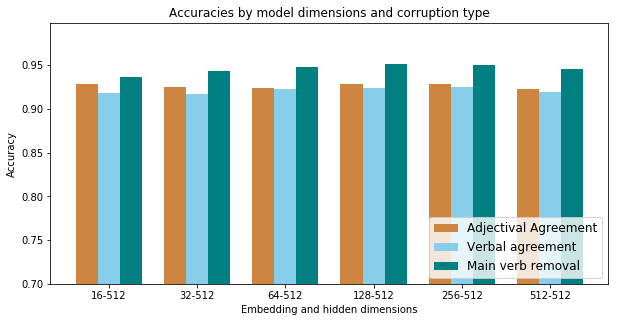

In [272]:
import matplotlib.pyplot as plt

#Graph with only the total accuracy
AA_numbers = [ accuracy_numbers['AA'][cond] for cond in ordered_conds ]
VA_numbers = [ accuracy_numbers['VA'][cond] for cond in ordered_conds ]
RV_numbers = [ accuracy_numbers['RV'][cond] for cond in ordered_conds]

ind = np.arange(len(accuracy_numbers['AA']))
width = 0.25

fig, ax = plt.subplots(figsize=(10,4.8))
#Make the rectangles
AA_rects = ax.bar(ind - width, AA_numbers, width,
               color="peru",
              label= "Adjectival Agreement",)
VA_rects = ax.bar(ind, VA_numbers, width,
               color="skyblue",
              label= "Verbal agreement")

RV_rects = ax.bar(ind + width, RV_numbers, width,
               color="teal",
              label= "Main verb removal")
# Add the labels
ax.set_ylabel("Accuracy")
ax.set_xlabel("Embedding and hidden dimensions")
ax.set_title('Accuracies by model dimensions and corruption type')
ax.set_xticks(ind)
ax.set_xticklabels(ordered_conds)
ax.set_ylim(bottom=0.7)
ax.legend(loc='lower right', fontsize=12)
plt.show

In [202]:
accuracy_G

{'AA': {'128-128': 0.9354688199870602,
  '256-256': 0.9323520629074802,
  '32-32': 0.9137634997262728,
  '512-1024': 0.9375466580401135,
  '512-512': 0.9254031254665804,
  '64-64': 0.9196424127805704},
 'RV': {'128-128': 0.952575774245008,
  '256-256': 0.9493852797183564,
  '32-32': 0.933322790032455,
  '512-1024': 0.9544941966004731,
  '512-512': 0.9462979261785577,
  '64-64': 0.9422204191649706},
 'VA': {'128-128': 0.9445402603408904,
  '256-256': 0.9413317660207926,
  '32-32': 0.9231310279707478,
  '512-1024': 0.9453785156137089,
  '512-512': 0.9344137512405215,
  '64-64': 0.9306078795995645}}

In [290]:
build_2layer_bar_plot

<function __main__.build_2layer_bar_plot(accuracy_G, accuracy_U, ordered_conds, x_label, title)>

In [ ]:
# Build contingency table and test for single comparison
trial = build_contingency_table(accuracy_tables["VA"]["exp-1.1_128-128"], 
                        accuracy_tables["VA"]["exp-1.1_128-128"])

result = mcnemar(trial, exact=False, correction=True)
print('statistic={}, p-value={}'.format(result.statistic, result.pvalue))